<a href="https://colab.research.google.com/github/ajay47847/pcg_classification/blob/main/ZsrSkewKortFeatSvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


    Record Name  Zero Crossing Rate   Kurtosis  Skewness  Type (-1=normal 1=abnormal)
0     f0001.wav              0.5604  22.793595  0.393832                           -1
1     f0002.wav              0.5504   9.824735  0.044023                           -1
2     f0003.wav              0.3636  21.751029  0.320183                            1
3     f0004.wav              0.3148  16.316796  0.272763                           -1
4     f0005.wav              0.2552   9.035164  0.226321                           -1
5     f0006.wav              0.3220  15.106003 -0.032977                           -1
6     f0007.wav              0.1836   5.533786 -0.032579                            1
7     f0008.wav              0.1684   9.087898 -0.082320                            1
8     f0009.wav              0.1796   7.682049 -0.168273                           -1
9     f0010.wav              0.2404  22.162328  0.342586                           -1
10    f0011.wav              0.3820  17.235157  0.0128

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


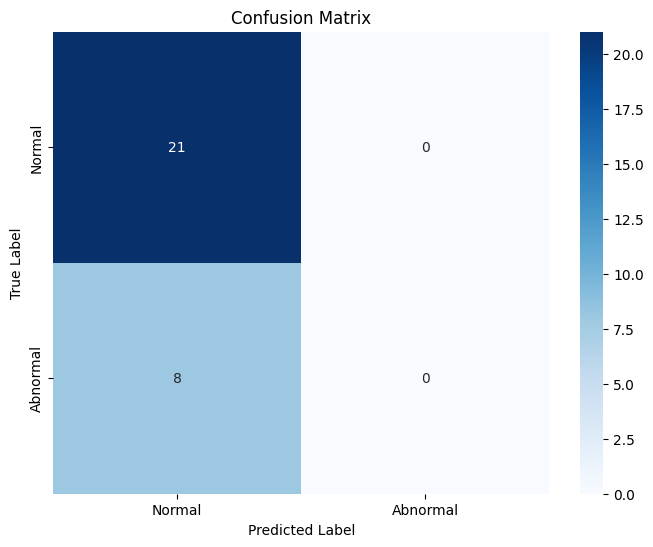

In [4]:
import pandas as pd
import numpy as np
import os
from scipy.io import wavfile
from scipy.signal import butter, filtfilt
from scipy.stats import kurtosis, skew
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


# Function to load audio files from a specified folder
def load_audio_files(file_list, folder_path):
    audio_data = []
    record_names = []
    min_length = float('inf')
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        sr, y = wavfile.read(file_path)  # Load the audio file
        audio_data.append(y)
        record_names.append(file_name)
        min_length = min(min_length, len(y))
    # Trim all audio files to the minimum length
    audio_data = [audio[:min_length] for audio in audio_data]
    return np.array(audio_data), record_names, sr

# Function to apply a bandpass filter
def apply_filter(data, sample_rate, filter_type, cutoff_freqs):
    nyquist = 0.5 * sample_rate
    normalized_cutoff = [freq / nyquist for freq in cutoff_freqs]
    b, a = butter(N=1, Wn=normalized_cutoff, btype=filter_type)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Function to normalize audio data using z-score
def z_score_normalize_audio_data(audio_data):
    normalized_audio = []
    for signal in audio_data:
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        if std_val == 0:
            normalized_signal = signal - mean_val
        else:
            normalized_signal = (signal - mean_val) / std_val
        normalized_audio.append(normalized_signal)
    return np.array(normalized_audio)

# Feature extraction functions
def calculate_zero_crossing_rate(audio_data):
    zero_crossing_rates = []
    for signal in audio_data:
        zsr = np.sum(np.abs(np.diff(np.sign(signal)))) / len(signal)
        zero_crossing_rates.append(zsr)
    return np.array(zero_crossing_rates)

def calculate_kurtosis(audio_data):
    kurtosis_values = []
    for signal in audio_data:
        kurtosis_values.append(kurtosis(signal))
    return np.array(kurtosis_values)

def calculate_skewness(audio_data):
    skewness_values = []
    for signal in audio_data:
        skewness_values.append(skew(signal))
    return np.array(skewness_values)


# Load the Excel file and select relevant columns
df = pd.read_excel('/content/PMEA_37_12_2181_OnlineAppendix.xlsx', sheet_name='SUAHSDB')

# Define the folder path containing the audio files
folder_path = '/content/drive/MyDrive/training-f'

# Get a list of all .wav files in the folder
audio_files = [file for file in os.listdir(folder_path) if file.endswith('.wav')]

# Filter the audio files based on record names
audio_files_filtered = [file for file in audio_files if any(record in file for record in df['Record name'])]

# Load audio data
audio_data, record_names_loaded, sample_rate = load_audio_files(audio_files_filtered, folder_path)

# Extract 2.5 seconds of audio
duration = 2.5
num_samples = int(duration * sample_rate)
audio_data = audio_data[:, :num_samples]

# Apply bandpass filter
audio_data_bandpass = apply_filter(audio_data, sample_rate, 'band', [25, 600])

# Z-normalize the audio data
audio_data_norm = z_score_normalize_audio_data(audio_data_bandpass)

# Extract features
zero_crossing_rates = calculate_zero_crossing_rate(audio_data_norm)
kurtosis_values = calculate_kurtosis(audio_data_norm)
skewness_values = calculate_skewness(audio_data_norm)

# Create DataFrame for features with record names and types
df_features = pd.DataFrame({
    'Record Name': record_names_loaded,
    'Zero Crossing Rate': zero_crossing_rates,
    'Kurtosis': kurtosis_values,
    'Skewness': skewness_values,
})

# Sort DataFrame by 'Record Name' in ascending order and reset index
df_features_sorted = df_features.sort_values(by='Record Name').reset_index(drop=True)

# Reassign the 'Type' column to maintain its original order
df_features_sorted['Type (-1=normal 1=abnormal)'] = df['Type (-1=normal 1=abnormal)']


# Print the sorted DataFrame with the updated index
print(df_features_sorted.to_string())


# Separate features and labels
X = df_features_sorted[['Zero Crossing Rate', 'Kurtosis', 'Skewness']].values
y = df_features_sorted['Type (-1=normal 1=abnormal)'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

# Initialize SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Predict labels for test set
y_pred = svm_classifier.predict(X_test)

# Print classification report
print((y_test, y_pred))

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy as a percentage with two decimal places
print(f'Accuracy: {accuracy * 100:.2f}%')

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate additional metrics
tn, fp, fn, tp = conf_matrix.ravel()

# Sensitivity (Recall)
sensitivity = recall_score(y_test, y_pred)
print(f"Sensitivity (Recall): {sensitivity:.2f}")

# Specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.2f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

# Display confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

